We have dataset from Asle, processed with 2 pointers to find repeatitions in Lakh MIDI Clean midi files

In [110]:
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [111]:
def analyze_datasets_folder(root_dir='/datasets'):
    """
    Analyzes the dataset folder and provides statistics about the number of files, MIDI files, and file extension distribution.

    Args:
        root_dir (str): The root directory of the dataset. Default is '/datasets'.
    """
    total_files = 0
    midi_files = 0
    folder_count = 0
    file_extensions = Counter()

    for root, dirs, files in os.walk(root_dir):
        folder_count += 1
        total_files += len(files)
        
        for file in files:
            _, ext = os.path.splitext(file)
            if ext:
                file_extensions[ext.lower()] += 1
            else:
                file_extensions['(no extension)'] += 1
            
            if ext.lower() in ['.mid', '.midi']:
                midi_files += 1

    print(f"Total number of folders: {folder_count}")
    print(f"Total number of files: {total_files}")
    print(f"Number of MIDI files: {midi_files}")
    
    print("\nFile extension distribution:")
    for ext, count in file_extensions.most_common():
        print(f"{ext}: {count}")
    
    print("\nPercentage breakdown:")
    sorted_extensions = sorted(file_extensions.items(), key=lambda x: x[1], reverse=True)
    
    for ext, count in sorted_extensions[:5]:  # Show top 5 extensions
        percentage = (count / total_files) * 100
        print(f"{ext}: {percentage:.2f}%")

    other_count = sum(count for ext, count in sorted_extensions[5:])
    other_percentage = (other_count / total_files) * 100
    print(f"Others: {other_percentage:.2f}%")

In [112]:
# checking the dataset folder's path
!ls -la

total 1096
drwxr-xr-x@ 5 serdegsenere  staff     160 Nov  9 15:31 .
drwxr-xr-x  7 serdegsenere  staff     224 Sep 26 12:55 ..
-rw-r--r--@ 1 serdegsenere  staff  509449 Nov  9 16:05 Clustering_repeated_motifs.ipynb
-rw-r--r--@ 1 serdegsenere  staff   43281 Nov  9 15:31 Scatter plot of first two components.png
-rw-r--r--@ 1 serdegsenere  staff    2173 Nov  9 15:29 feature_statistics.txt


In [113]:
os.getcwd()

'/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/testing_tools/clustering'

ipynb has different paths concept, ok, let's use full path instead

In [114]:
# checking the dataset folder, NOTE that it is in gitignore, so it is not pushed to github
analyze_datasets_folder("/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only") 

Total number of folders: 3484
Total number of files: 7669
Number of MIDI files: 7662

File extension distribution:
.mid: 7662
(no extension): 7

Percentage breakdown:
.mid: 99.91%
(no extension): 0.09%
Others: 0.00%


The plan for this ipynb something like this

	1.	Preprocessing
			Parsing MIDI files with mido or better pretty_midi
			Extract key features -- note sequences, rhythm, harmony
			Normalize key and tempo
	2.	Feature representation
			Convert MIDI files to fixed-length vectors (bag-of-notes, TF-IDF, autoencoders??)
			Use dimensionality reduction if needed?
	3.	Similarity measurement
			Distance metrics like Euclidean, Cosine, DTW
	4.	Efficient retrieval
			Indexing structures like FAISS or LSH for fast searches?
	5.	Building the program for integreation later

(add references)

In [115]:
%pip install mido
%pip install pretty_midi
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install faiss-cpu  # for similarity search

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [116]:
import os
import numpy as np
import pretty_midi
import faiss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [117]:
def extract_features(file_path):
    """
    Extract features from a MIDI file using a dictionary structure.
    Focuses on pitch, duration, rhythm, and tempo features.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None
    
    # Initialize feature structure
    detailed_features = {
        'pitch_features': {'values': []},
        'duration_features': {'values': []},
        'rhythm_features': {
            'onset_times': [],
            'ioi_values': [],
            'beat_positions': [],
            'syncopation': []
        },
        'tempo': midi_data.estimate_tempo(),
        'time_signature': None,
        'key_signature': None
    }
    
    # Extract time and key signatures
    for ts in midi_data.time_signature_changes:
        detailed_features['time_signature'] = f"{ts.numerator}/{ts.denominator}"
        break
        
    for ks in midi_data.key_signature_changes:
        detailed_features['key_signature'] = ks.key_number
        break

    # Collect note features and onset times
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                detailed_features['pitch_features']['values'].append(note.pitch)
                detailed_features['duration_features']['values'].append(note.end - note.start)
                detailed_features['rhythm_features']['onset_times'].append(note.start)
    
    if not detailed_features['pitch_features']['values']:
        return None

    # Process rhythm features
    if len(detailed_features['rhythm_features']['onset_times']) > 0:
        onset_times = sorted(detailed_features['rhythm_features']['onset_times'])
        ioi_values = np.diff(onset_times)
        detailed_features['rhythm_features']['ioi_values'] = ioi_values.tolist()
        
        if detailed_features['time_signature']:
            beats_per_measure = int(detailed_features['time_signature'].split('/')[0])
            beat_duration = 60.0 / detailed_features['tempo']
            beat_positions = [t % (beats_per_measure * beat_duration) / beat_duration 
                            for t in onset_times]
            detailed_features['rhythm_features']['beat_positions'] = beat_positions
            
            syncopation = [1 if not np.isclose(pos % 1, 0, atol=0.1) else 0 
                          for pos in beat_positions]
            detailed_features['rhythm_features']['syncopation'] = syncopation

    # Calculate statistics
    for feature_type in ['pitch_features', 'duration_features']:
        values = np.array(detailed_features[feature_type]['values'])
        detailed_features[feature_type].update({
            'values': values.tolist(),
            'mean': float(np.mean(values)),
            'std': float(np.std(values)),
            'min': float(np.min(values)),
            'max': float(np.max(values))
        })
    
    # Add rhythm statistics
    if len(detailed_features['rhythm_features']['ioi_values']) > 0:
        ioi_values = np.array(detailed_features['rhythm_features']['ioi_values'])
        detailed_features['rhythm_features'].update({
            'ioi_mean': float(np.mean(ioi_values)),
            'ioi_std': float(np.std(ioi_values)),
            'syncopation_ratio': float(np.mean(detailed_features['rhythm_features']['syncopation']))
            if detailed_features['rhythm_features']['syncopation'] else 0.0
        })
    else:
        detailed_features['rhythm_features'].update({
            'ioi_mean': 0.0,
            'ioi_std': 0.0,
            'syncopation_ratio': 0.0
        })
    
    # Create simplified features for clustering
    simplified_features = {
        'tempo': float(detailed_features['tempo']),
        'pitch_mean': float(detailed_features['pitch_features']['mean']),
        'pitch_std': float(detailed_features['pitch_features']['std']),
        'duration_mean': float(detailed_features['duration_features']['mean']),
        'duration_std': float(detailed_features['duration_features']['std']),
        'ioi_mean': float(detailed_features['rhythm_features']['ioi_mean']),
        'ioi_std': float(detailed_features['rhythm_features']['ioi_std']),
        'syncopation_ratio': float(detailed_features['rhythm_features']['syncopation_ratio'])
    }
    
    return simplified_features

In [118]:
def extract_rhythmic_features(midi_data): 
# FOR LATER, not used now directly since it is mostly in the extract_features function
    """
    Extract rhythmic features from a MIDI file.

    Args:
        midi_data (pretty_midi.PrettyMIDI): The MIDI data.

    Returns:
        numpy.ndarray: A feature vector representing the rhythmic features.
    """
    # Calculate inter-onset intervals (IOIs)
    onset_times = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            onset_times.extend([note.start for note in instrument.notes])
    onset_times = sorted(onset_times)
    iois = np.diff(onset_times)
    return iois

In [119]:
def process_dataset(dataset_folder):
    """
    Process a dataset folder and extract features from all MIDI files.
    
    Args:
        dataset_folder (str): The path to the dataset folder.
        
    Returns:
        tuple: (feature_matrix, file_names, feature_stats)
            - feature_matrix: numpy array of shape (n_files, n_features)
            - file_names: list of file paths
            - feature_stats: dictionary with feature statistics
    """
    feature_list = []
    file_names = []
    
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.lower().endswith(('.mid', '.midi')):
                midi_path = os.path.join(root, file)
                try:
                    # Load and process MIDI file
                    midi_data = pretty_midi.PrettyMIDI(midi_path)
                    
                    # Get all notes across all instruments
                    notes = []
                    for instrument in midi_data.instruments:
                        notes.extend(instrument.notes)
                    
                    if not notes:
                        print(f"No notes found in {midi_path}")
                        continue
                        
                    # Extract features
                    pitches = [note.pitch for note in notes]
                    durations = [note.end - note.start for note in notes]
                    start_times = [note.start for note in notes]
                    iois = np.diff(sorted(start_times))  # Inter-onset intervals
                    
                    # Calculate syncopation
                    beat_times = midi_data.get_beats()
                    syncopation_count = 0
                    for start_time in start_times:
                        closest_beat = min(beat_times, key=lambda x: abs(x - start_time))
                        if abs(start_time - closest_beat) > 0.1:  # Threshold for syncopation
                            syncopation_count += 1
                    
                    # Create feature vector
                    features = [
                        float(midi_data.estimate_tempo()),
                        float(np.mean(pitches)),
                        float(np.std(pitches)),
                        float(np.mean(durations)),
                        float(np.std(durations)),
                        float(np.mean(iois)) if len(iois) > 0 else 0.0,
                        float(np.std(iois)) if len(iois) > 0 else 0.0,
                        float(syncopation_count / len(notes)) if notes else 0.0
                    ]
                    
                    feature_list.append(features)
                    file_names.append(midi_path)
                    
                except Exception as e:
                    print(f"Error processing {midi_path}: {str(e)}")
                    continue
    
    if not feature_list:
        raise ValueError("No valid MIDI files found in the dataset folder")
    
    feature_matrix = np.array(feature_list)
    feature_stats = {
        'n_files': len(file_names),
        'feature_names': ['tempo', 'pitch_mean', 'pitch_std',
                         'duration_mean', 'duration_std',
                         'ioi_mean', 'ioi_std', 'syncopation_ratio']
    }
    
    return feature_matrix, file_names, feature_stats

In [120]:
# note that this folder is in gitignore, so it is not pushed to github, I took it from Teams
dataset_folder = "/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only"

In [121]:
os.listdir(dataset_folder)

['Dave_Matthews_Band_Patterns',
 'Dee_Patterns',
 'LaBelle_Patterns',
 'A_Taste_of_Honey_Patterns',
 'Journey_Patterns',
 'Gipsy_Kings_Patterns',
 'George_Baker_Selection_Patterns',
 '2_Unlimited_Patterns',
 'Jimmy_Ruffin_Patterns',
 'Barbra_Streisand_Patterns',
 'Alizee_Patterns',
 'Dionne_Warwick_Patterns',
 'Joseph_Lamb_Patterns',
 'Franky_Boy_Patterns',
 'Lavinia_Jones_Patterns',
 'Anita_Ward_Patterns',
 'Hank_Williams_Patterns',
 'Eddie_Money_Patterns',
 'Darude_Patterns',
 'Joe_Cocker_Patterns',
 'Houston_Thelma_Patterns',
 'Barry_and_Eileen_Patterns',
 'Eros_Ramazzotti_Patterns',
 'Just_Friends_Patterns',
 'Joe_Satriani_Patterns',
 'Herbie_Hancock_Patterns',
 'Barenaked_Ladies_Patterns',
 'Axelle_Red_Patterns',
 'Lipps,_Inc_Patterns',
 'Gerry_Rafferty_Patterns',
 'Freda_Payne_Patterns',
 'Edwyn_Collins_Patterns',
 'Joni_Mitchell_Patterns',
 'Detroit_Emeralds_Patterns',
 'Johnny_Kemp_Patterns',
 'Jackie_Wilson_Patterns',
 'Ambra_Patterns',
 'John_Paul_Young_Patterns',
 'Imperial_

In [122]:
# let's try to process only a part of the dataset
feature_list, file_names, feature_stats = process_dataset("/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns")


In [123]:
# let's see the first 10 file names
len(file_names)

22

In [124]:
# let's see 10 files
print("total files itn the folder is " + str(len(file_names)))
file_names[0:10]



total files itn the folder is 22


['/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Stuck.mid/track1.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Stuck.mid/track0.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Faith.mid/track2.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Faith.mid/track1.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Faith.mid/track0.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/N_2_Gether_Now.mid/track1.mid',
 '/Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/N_2_Gether_Now.mid/track0.mid',
 '

In [125]:
# vector of features for the 1st file
feature_list[0:1]

array([[1.88054820e+02, 5.03666667e+01, 7.31277421e+00, 2.21554458e-01,
        7.12375250e-02, 1.84233589e+00, 1.46677570e+01, 7.33333333e-01]])

In [126]:
feature_stats


{'n_files': 22,
 'feature_names': ['tempo',
  'pitch_mean',
  'pitch_std',
  'duration_mean',
  'duration_std',
  'ioi_mean',
  'ioi_std',
  'syncopation_ratio']}

In [127]:
# let's see the shape of the 1st, 2nd and 3rd file
print(np.shape(feature_list[0:1]))  
print(np.shape(feature_list[1:2]))
print(np.shape(feature_list[2:3]))



(1, 8)
(1, 8)
(1, 8)


oi, oi oi, there can be a difference in vector sizes and this will create problems as many ML algorithms expect fixed length inputs


In [128]:
# analyzing the lengths of the feature vectors
feature_lengths = [len(f) for f in feature_list]
fixed_length = min(6666, max(feature_lengths))  # set an upper limit here
print(f"Using fixed length: {fixed_length}")

Using fixed length: 8


In [129]:
def pad_or_truncate(features, fixed_length):
    """
    Pad or truncate the feature vector to the fixed length.

    Args:
        features (numpy.ndarray): The feature vector to pad or truncate.
        fixed_length (int): The length to which the feature vector should be padded or truncated.

    Returns:
        numpy.ndarray: The padded or truncated feature vector.
    """
    if len(features) >= fixed_length:
        return features[:fixed_length]
    else:
        padding = np.zeros(fixed_length - len(features))
        return np.concatenate((features, padding))

In [130]:
# Apply to all feature vectors
processed_features = [pad_or_truncate(f, fixed_length) for f in feature_list]
processed_features = np.array(processed_features)

# Normalize the features
scaler = StandardScaler()
processed_features = scaler.fit_transform(processed_features)

### Similarity Search Index
FAISS for efficient similarity searches in high-dimensional spaces

FAISS -- Facebook AI Similarity Search (https://ai.meta.com/tools/faiss/)

In [131]:
n_samples, n_features = processed_features.shape

print(f"Number of samples: {n_samples}")
print(f"Number of features per sample: {n_features}")


Number of samples: 22
Number of features per sample: 8


In [132]:
# Create a DataFrame with named columns
column_names = ['tempo', 
                'pitch_mean', 'pitch_std',
                'duration_mean', 'duration_std',
                # 'velocity_mean', 'velocity_std',
                'ioi_mean', 'ioi_std', 'syncopation_ratio']

df_features = pd.DataFrame(feature_list, columns=column_names)
df_features['file_name'] = file_names

print(f"Extracted features for {len(df_features)} files.")

Extracted features for 22 files.


In [133]:
print(df_features.shape)
print(df_features.columns)
print(df_features.head())

(22, 9)
Index(['tempo', 'pitch_mean', 'pitch_std', 'duration_mean', 'duration_std',
       'ioi_mean', 'ioi_std', 'syncopation_ratio', 'file_name'],
      dtype='object')
       tempo  pitch_mean  pitch_std  duration_mean  duration_std  ioi_mean  \
0  188.05482   50.366667   7.312774       0.221554      0.071238  1.842336   
1  206.39840   40.044118   8.558508       0.305559      0.230109  3.241627   
2  192.00000   27.527778   6.529787       0.313585      0.356172  2.348214   
3  192.00000   42.652174   8.217736       0.210598      0.122847  1.381944   
4  192.00000   53.863636   8.247840       0.152699      0.090397  0.054506   

     ioi_std  syncopation_ratio  \
0  14.667757           0.733333   
1  12.823514           0.632353   
2   8.267676           0.666667   
3   8.554928           0.695652   
4   0.088412           0.704545   

                                           file_name  
0  /Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSa...  
1  /Volumes/C/Algoritmi/SaMuGeD-Algorit

In [134]:
# feature statistics
print("\n=== Feature Statistics ===")
print(f"Total number of files analyzed: {len(df_features)}")

# Basic statistics for each feature
print("\n=== Basic Statistics ===")
stats_df = df_features[column_names].describe()
print(stats_df)

# Feature correlations
print("\n=== Feature Correlations ===")
corr_matrix = df_features[column_names].corr()
print(corr_matrix)



=== Feature Statistics ===
Total number of files analyzed: 22

=== Basic Statistics ===
            tempo  pitch_mean  pitch_std  duration_mean  duration_std  \
count   22.000000   22.000000  22.000000      22.000000  2.200000e+01   
mean   171.689029   41.382918   6.504957       0.290973  1.895099e-01   
std     48.363597   10.965583   2.214918       0.131418  1.685704e-01   
min     57.142857   27.527778   2.490104       0.070093  1.937984e-15   
25%    170.857143   33.011905   5.370230       0.183899  7.217814e-02   
50%    192.000000   39.855392   6.615360       0.278337  1.424293e-01   
75%    198.636334   46.543393   8.240314       0.384326  2.320891e-01   
max    230.487632   70.611111  10.231691       0.566037  6.966580e-01   

        ioi_mean    ioi_std  syncopation_ratio  
count  22.000000  22.000000          22.000000  
mean    1.497052   6.179903           0.655139  
std     1.511983   7.844529           0.174376  
min     0.054506   0.070057           0.166667  
25%     

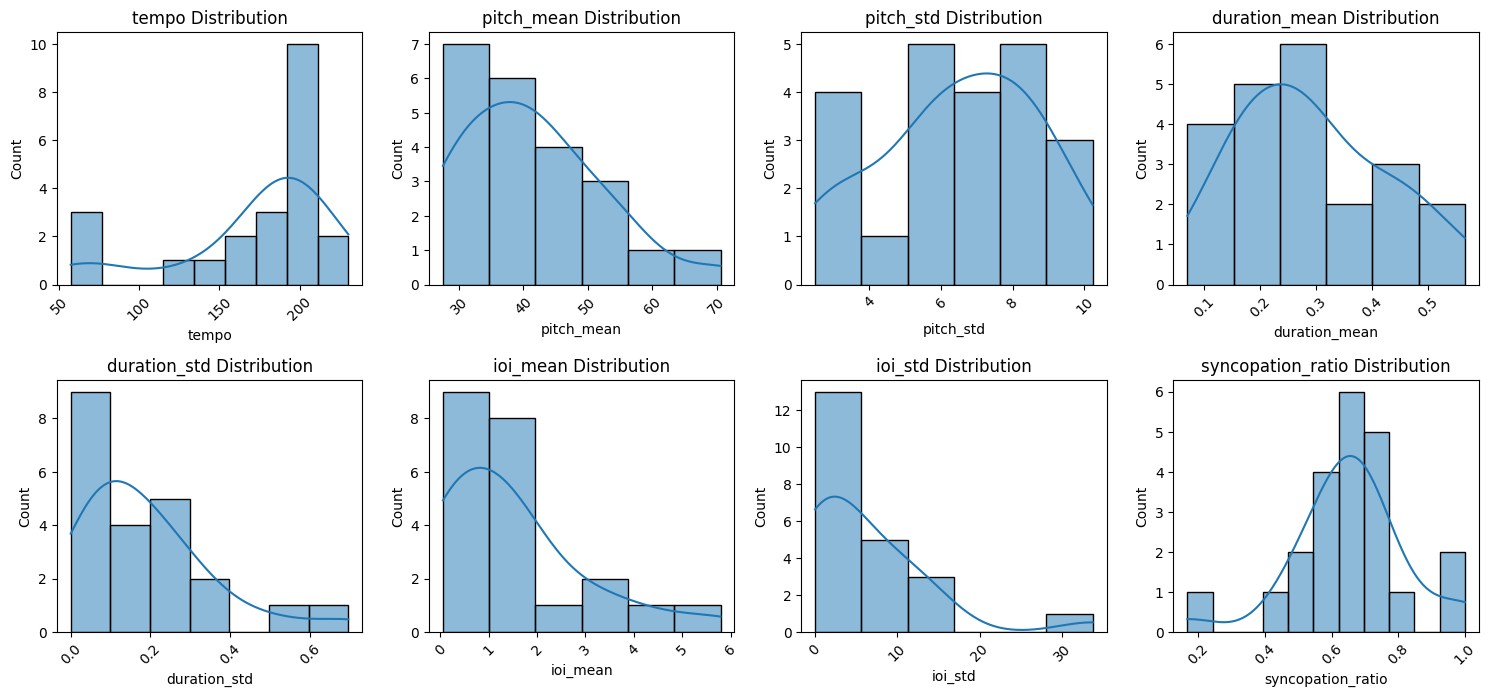

In [135]:
# Visualization of feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(column_names, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df_features[feature], kde=True)
    plt.title(f'{feature} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


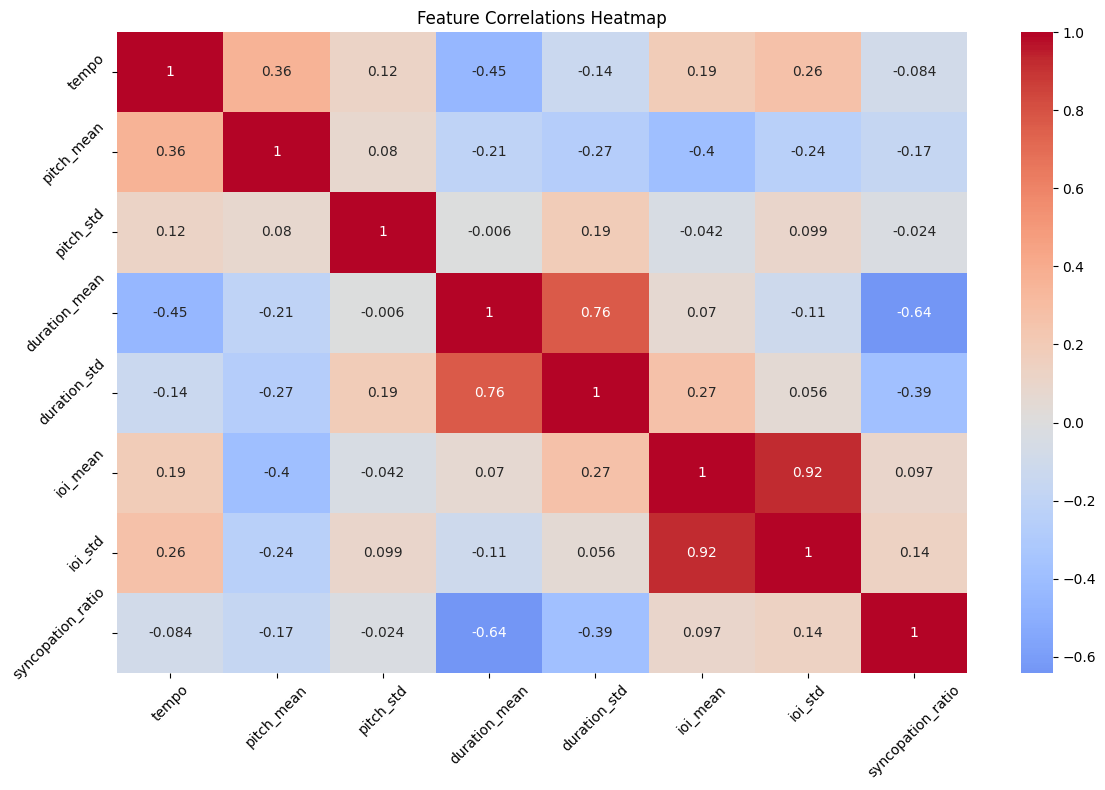

In [136]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [137]:
print(df_features.isna().sum())

tempo                0
pitch_mean           0
pitch_std            0
duration_mean        0
duration_std         0
ioi_mean             0
ioi_std              0
syncopation_ratio    0
file_name            0
dtype: int64


In [138]:
# df_features_clean = df_features.dropna()

In [139]:
# Save statistics to a file for later reference
with open('feature_statistics.txt', 'w') as f:
    f.write("=== MIDI Feature Statistics ===\n\n")
    f.write(f"Number of files analyzed: {len(df_features)}\n\n")
    f.write("Basic Statistics:\n")
    f.write(stats_df.to_string())
    f.write("\n\nFeature Correlations:\n")
    f.write(corr_matrix.to_string())

In [140]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df_features_clean = pd.DataFrame(imputer.fit_transform(df_features.iloc[:, :-1]), columns=df_features.columns[:-1])

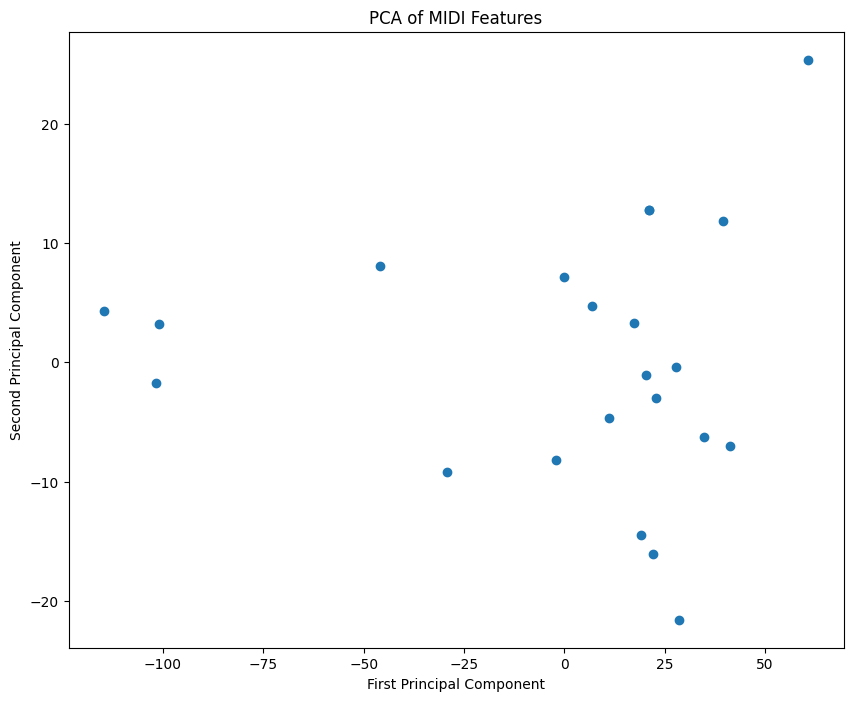

In [141]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_features_clean)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of MIDI Features')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


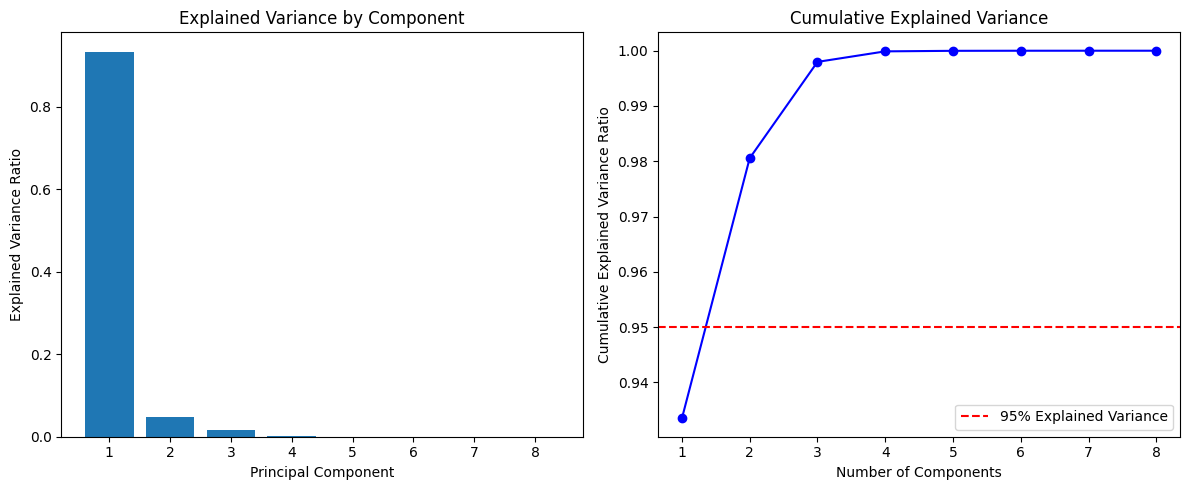

In [142]:
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(df_features_clean)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create visualization of explained variance
plt.figure(figsize=(12, 5))

# Plot 1: Explained variance ratio
plt.subplot(121)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')

# Plot 2: Cumulative explained variance
plt.subplot(122)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()

plt.tight_layout()
plt.show()


In [143]:
# Feature importance analysis
feature_names = df_features_clean.columns
components_df = pd.DataFrame(
    pca.components_,
    columns=feature_names
)

# Print explained variance for each component
print("\nExplained variance ratio by component:")
for idx, ratio in enumerate(explained_variance_ratio, 1):
    print(f"PC{idx}: {ratio:.3f} ({ratio*100:.1f}%)")

# Print top contributing features for first two components
print("\nTop contributing features:")
for i in range(2):
    sorted_idx = np.argsort(np.abs(pca.components_[i]))[::-1]
    print(f"\nPrincipal Component {i+1}:")
    for idx in sorted_idx[:3]:  # Show top 3 features
        print(f"{feature_names[idx]}: {pca.components_[i][idx]:.3f}")



Explained variance ratio by component:
PC1: 0.933 (93.3%)
PC2: 0.047 (4.7%)
PC3: 0.017 (1.7%)
PC4: 0.002 (0.2%)
PC5: 0.000 (0.0%)
PC6: 0.000 (0.0%)
PC7: 0.000 (0.0%)
PC8: 0.000 (0.0%)

Top contributing features:

Principal Component 1:
tempo: 0.995
pitch_mean: 0.085
ioi_std: 0.043

Principal Component 2:
pitch_mean: 0.891
ioi_std: -0.440
ioi_mean: -0.098


- Variance
  - PC1 explains 93.3% of the total variance in your data, which is extremely high
  - PC2 explains an additional 4.7%
  - Together, the first two components explain 98% of the variance
  - All other components (PC3-PC8) contribute very little (less than 2% combined)


- Feature Contributions:
    - First Principal Component (PC1):
      - Dominated by tempo (0.995)
      - This suggests that the main variation in your MIDI patterns is driven by tempo differences
      - Pitch mean and IOI standard deviation have minimal contribution
- Second Principal Component (PC2):
    - Mainly influenced by pitch_mean (0.891)
    - Has negative correlations with rhythm features (ioi_std: -0.440, ioi_mean: -0.098)
    - This component seems to capture the trade-off between pitch height and rhythmic complexity

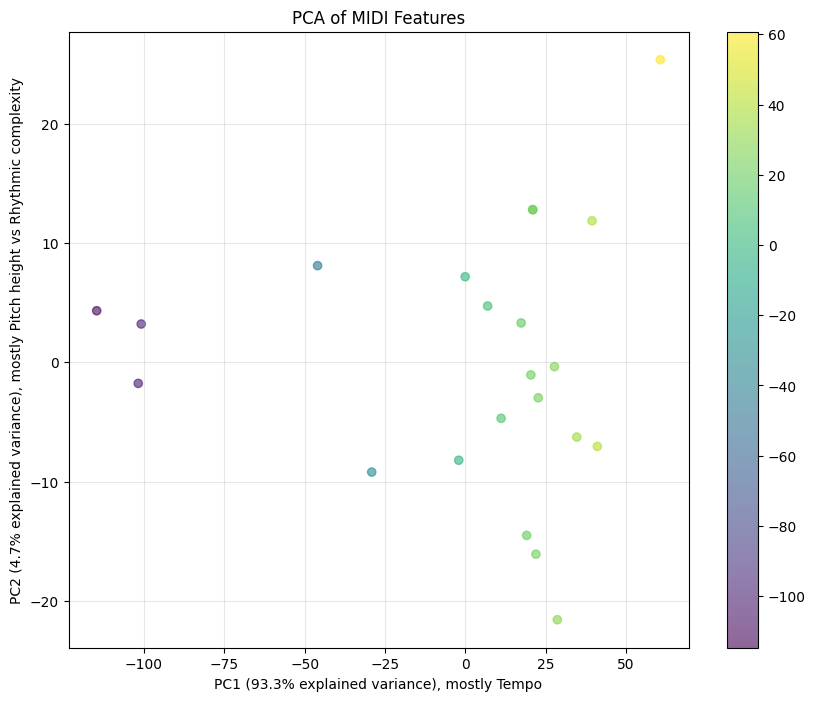

In [144]:
# Scatter plot of first two components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                     alpha=0.6, c=pca_result[:, 0], cmap='viridis')
plt.colorbar(scatter)
plt.title('PCA of MIDI Features')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} explained variance), mostly Tempo')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} explained variance), mostly Pitch height vs Rhythmic complexity')
plt.grid(True, alpha=0.3)
plt.show()

- Yellow points = faster tempo patterns
- Purple points = slower tempo patterns

## Scatter Plot analysis:
- The x-axis (PC1) primarily represents tempo variation
- The y-axis (PC2) represents the relationship between pitch height and rhythmic features
- The color gradient (viridis) shows the distribution along PC1
### The spread of points suggests:
- Clear separation along the tempo dimension
- Some clustering or patterns in the pitch-rhythm relationship
- Most variation is captured horizontally (PC1) rather than vertically (PC2)
### Practical Implications:
- we can reduce feature space to just 2 dimensions? while retaining 98% of the information
- Tempo is the most distinguishing feature of your MIDI patterns
- There's an interesting relationship between pitch height and rhythmic complexity ??
- The remaining features contribute very little to the overall variation **with these songs**

In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import faiss
import numpy as np

# After extracting features but before building FAISS index
def prepare_features_for_faiss(feature_list):
    """
    Prepare features for FAISS indexing by scaling and PCA transformation.
    """
    # Convert feature list to numpy array
    feature_matrix = np.array(feature_list)
    
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)
    
    # Apply PCA
    pca = PCA(n_components=2)  # or different number based on your needs
    pca_features = pca.fit_transform(scaled_features)
    
    return pca_features, scaler, pca

# Process features
feature_matrix = np.array(feature_list)
scaled_features = StandardScaler().fit_transform(feature_matrix)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Build FAISS index
def build_faiss_index(feature_matrix, d=2):
    feature_matrix = feature_matrix.astype('float32')
    index = faiss.IndexFlatL2(d)
    index.add(feature_matrix)
    return index

# Create the index
faiss_index = build_faiss_index(pca_features)

In [146]:
# prepare features and create global objects
pca_features, scaler, pca = prepare_features_for_faiss(feature_list)
faiss_index = build_faiss_index(pca_features)

def find_similar_midi(query_file_path, k=5, scaler=scaler, pca=pca, faiss_index=faiss_index):
    query_features = extract_features(query_file_path)
    if query_features is None:
        print("Failed to extract features from the query file.")
        return [], []
    
    # Debug print
    print("\nExtracted features:")
    for key, value in query_features.items():
        print(f"{key}: {value}")
    
    try:
        query_vector = np.array([
            query_features['tempo'],
            query_features['pitch_mean'],
            query_features['pitch_std'],
            query_features['duration_mean'],
            query_features['duration_std'],
            query_features['ioi_mean'],
            query_features['ioi_std'],
            query_features['syncopation_ratio']
        ])
        
        # Transform query using same scaler and PCA
        query_pca = pca.transform(scaler.transform(query_vector.reshape(1, -1)))
        query_pca = query_pca.astype('float32')
        
        # Use FAISS for efficient search
        distances, indices = faiss_index.search(query_pca, k)
        
        similar_files = [file_names[i] for i in indices[0]]
        return similar_files, distances[0]
        
    except KeyError as e:
        print(f"Missing feature: {e}")
        return [], []
    except Exception as e:
        print(f"Error in similarity search: {e}")
        return [], []

main with all the stuff

In [148]:
def main():
    """
    Main function to find similar MIDI files based on PCA-transformed features.
    """
    print("\nMIDI Similarity Search")
    print("=====================")
    
    # Print dataset information
    print(f"\nDatabase Summary:")
    print(f"Total MIDI files in database: {len(file_names)}")
    print(f"Database location: {dataset_folder}")
    print("Features used: tempo, pitch, duration, rhythm, syncopation")
    print("=====================")
    
    query_file = input("\nEnter the path to the MIDI file you want to compare: ").strip()
    if not os.path.exists(query_file):
        print("Error: File does not exist.")
        return
    
    if not query_file.lower().endswith(('.mid', '.midi')):
        print("Error: File must be a MIDI file (.mid or .midi)")
        return
    
    try:
        k = int(input("Enter the number of similar files to retrieve (1-10): "))
        if k < 1 or k > 10:
            print("Error: Please enter a number between 1 and 10")
            return
            
        print("\nAnalysis Summary:")
        print(f"Query file: {os.path.basename(query_file)}")
        print(f"Full path: {query_file}")
        print(f"Searching for {k} most similar files...")
            
        # Extract and process features
        similar_files, distances = find_similar_midi(query_file, k)
        
        if not similar_files:
            print("No similar files found or error in processing query file.")
            return
            
        print("\nResults:")
        print("--------")
        print(f"Found {len(similar_files)} similar files:")
        
        for i, (file, distance) in enumerate(zip(similar_files, distances), 1):
            similarity = 1 / (1 + distance)
            print(f"\n{i}. File: {os.path.basename(file)}")
            print(f"   Artist/Song: {os.path.dirname(file).split('/')[-2]}")  # Assuming folder structure
            print(f"   Full path: {file}")
            print(f"   Similarity score: {similarity:.2%}")
            
        # Feature comparison
        if input("\nShow detailed feature comparison? (y/n): ").lower().strip() == 'y':
            print("\nFeature Comparison Analysis:")
            print("--------------------------")
            print(f"Comparing: {os.path.basename(query_file)} with {os.path.basename(similar_files[0])}")
            
            query_features = extract_features(query_file)
            most_similar_features = extract_features(similar_files[0])
            
            if query_features and most_similar_features:
                feature_names = ['tempo', 'pitch_mean', 'pitch_std', 
                               'duration_mean', 'duration_std',
                               'ioi_mean', 'ioi_std', 'syncopation_ratio']
                
                print("\nDetailed Feature Comparison:")
                for name in feature_names:
                    query_val = query_features.get(name, 'N/A')
                    similar_val = most_similar_features.get(name, 'N/A')
                    print(f"\n{name}:")
                    print(f"  Query file:    {query_val}")
                    print(f"  Similar file:  {similar_val}")
                    if query_val != 'N/A' and similar_val != 'N/A':
                        diff = abs(float(query_val) - float(similar_val))
                        print(f"  Difference:    {diff:.4f}")
        
        print("\nSearch Complete!")
        print("================")
        print(f"Query file: {os.path.basename(query_file)}")
        print(f"Most similar file: {os.path.basename(similar_files[0])}")
        print(f"Number of files compared: {len(file_names)}")
                    
    except ValueError:
        print("Error: Please enter a valid number for k.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise  # For debugging


In [149]:
if __name__ == '__main__':
    main()


MIDI Similarity Search

Database Summary:
Total MIDI files in database: 22
Database location: /Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only
Features used: tempo, pitch, duration, rhythm, syncopation

Analysis Summary:
Query file: track1.mid
Full path: /Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Stuck.mid/track1.mid
Searching for 4 most similar files...

Extracted features:
tempo: 188.0548195945233
pitch_mean: 50.36666666666667
pitch_std: 7.312774211382892
duration_mean: 0.22155445763888745
duration_std: 0.07123752502375351
ioi_mean: 1.842335893258427
ioi_std: 14.667757003642144
syncopation_ratio: 0.9555555555555556

Results:
--------
Found 4 similar files:

1. File: track1.mid
   Artist/Song: Limp_Bizkit_Patterns
   Full path: /Volumes/C/Algoritmi/SaMuGeD-Algoritmi-DrDreSamplerAI-2024/datasets/two_pointers_repeats_only/Limp_Bizkit_Patterns/Stuck.mid/track1.mid
   Simi